In [1]:
# Preprocessing data from bigquery with pandas using pandas-gbq library

In [2]:
# venv_dev
"""
python3 -m venv venv_dev
source venv_dev/bin/activate
pip install ipykernel
pip install google-cloud-bigquery 
pip install google-cloud-storage
pip install pandas
pip install pyarrow
pip install pandas-gbq
pip install tqdm
pip install matplotlib
"""

'\npython3 -m venv venv_dev\nsource venv_dev/bin/activate\npip install ipykernel\npip install google-cloud-bigquery \npip install google-cloud-storage\npip install pandas\npip install pyarrow\npip install pandas-gbq\npip install tqdm\npip install matplotlib\n'

In [1]:
import pandas as pd
import pandas_gbq
import os
from IPython.display import display
from google.cloud import bigquery

In [2]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "key-vlille-gcp-etl.json"

In [3]:
client = bigquery.Client()

In [4]:
PROJECT_ID="vlille-gcp-etl"
DATASET_NAME="vlille_ml_test"

In [5]:
query = f"""
SELECT
    *
FROM
    `{DATASET_NAME}.stations`
WHERE
    lower(name) LIKE '%republique%'
ORDER BY
    id
"""


df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID, location='us')
display(df.head())

Downloading: 100%|██████████|


,id,name,adress,city,type,latitude,longitude
0,6,REPUBLIQUE BEAUX ARTS,2 RUE INKERMAN,LILLE,AVEC TPE,50.630943,3.060299
1,144,ANNAPPES REPUBLIQUE,FACE AU 1 BIS RUE DE LA STATION,VILLENEUVE D'ASCQ,AVEC TPE,50.625800,3.148620
2,264,REPUBLIQUE,203 RUE CARNOT,WATTRELOS,AVEC TPE,50.697895,3.206297


In [6]:
query = f"""
SELECT
    *
FROM
    `{DATASET_NAME}.records`
    LIMIT 10
"""

df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID)
display(df)

Downloading: 100%|██████████|


,station_id,etat,nb_velos_dispo,nb_places_dispo,etat_connexion,derniere_maj,record_timestamp,rn
0,<NA>,None,<NA>,<NA>,None,NaT,2023-09-07 05:09:01.353000+00:00,1
1,<NA>,None,<NA>,<NA>,None,NaT,2023-08-25 04:59:01.454000+00:00,1
2,<NA>,None,<NA>,<NA>,None,NaT,2023-09-03 22:59:00.677000+00:00,1
3,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2023-11-22 04:56:03.073000+00:00,1
4,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2023-09-26 17:27:01.009000+00:00,1
5,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2023-09-19 05:20:00.951000+00:00,1
6,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2024-01-29 04:32:01.530000+00:00,1
7,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2024-02-03 15:34:00.740000+00:00,1
8,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2024-01-15 10:32:02.009000+00:00,1
9,1,RÉFORMÉ,0,0,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2024-01-06 13:21:01.194000+00:00,1


In [9]:
# copy the record table with bigquery client to another table named records_copy
table_id = f"{PROJECT_ID}.{DATASET_NAME}.records"
table_id_copy = f"{PROJECT_ID}.{DATASET_NAME}.records_copy"

job = client.copy_table(table_id, table_id_copy)
job.result()  # Wait for the job to complete.

print(f"Table {table_id} copied to {table_id_copy}.")

Table vlille-gcp-etl.vlille_ml_test.records copied to vlille-gcp-etl.vlille_ml_test.records_copy.


In [7]:
# get the number of rows in the records_copy table
query = f"""
SELECT
    COUNT(*) as nb_rows
FROM
    `{DATASET_NAME}.records_copy`
"""

df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID)
display(df)

Downloading: 100%|██████████|


,nb_rows
0,66801099


In [11]:
query = f"""
SELECT
    r.*
FROM
    `{DATASET_NAME}.records_copy` r
JOIN
    (
        SELECT
            station_id,
            MAX(record_timestamp) as max_timestamp
        FROM
            `{DATASET_NAME}.records_copy`
        GROUP BY
            station_id
    ) subq
ON
    r.station_id = subq.station_id AND
    r.record_timestamp = subq.max_timestamp
LIMIT 10
"""

df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID)
display(df)

Downloading: 100%|██████████|


,station_id,etat,nb_velos_dispo,nb_places_dispo,etat_connexion,derniere_maj,record_timestamp,rn
0,60,EN SERVICE,16,4,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
1,257,EN SERVICE,7,8,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
2,239,EN SERVICE,5,8,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
3,167,EN SERVICE,7,13,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
4,18,EN SERVICE,13,1,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
5,56,EN SERVICE,8,10,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
6,190,EN SERVICE,2,12,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
7,273,EN SERVICE,7,13,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1
8,262,RÉFORMÉ,0,1,DÉCONNECTÉ,2022-11-29 09:47:16+00:00,2024-02-06 19:50:02.807000+00:00,1
9,20,EN SERVICE,23,7,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00,1


In [8]:
# query to get the number of available places for the station_id = 6, ordered by distinct record_timestamp
query = f"""
SELECT
    station_id, 
    etat,
    nb_velos_dispo,
    nb_places_dispo,
    etat_connexion,
    derniere_maj,
    record_timestamp
FROM
    `{DATASET_NAME}.records_copy`
WHERE 
  station_id = 6
  AND record_timestamp >= '2023-09-10'
ORDER BY record_timestamp DESC
"""

df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID)
display(df.head())

Downloading: 100%|██████████|


,station_id,etat,nb_velos_dispo,nb_places_dispo,etat_connexion,derniere_maj,record_timestamp
0,6,EN SERVICE,0,23,CONNECTÉ,2024-02-06 19:48:13+00:00,2024-02-06 19:50:02.807000+00:00
1,6,EN SERVICE,0,23,CONNECTÉ,2024-02-06 19:47:14+00:00,2024-02-06 19:49:01.170000+00:00
2,6,EN SERVICE,0,23,CONNECTÉ,2024-02-06 19:46:12+00:00,2024-02-06 19:48:01.326000+00:00
3,6,EN SERVICE,0,23,CONNECTÉ,2024-02-06 19:45:13+00:00,2024-02-06 19:47:01.241000+00:00
4,6,EN SERVICE,0,23,CONNECTÉ,2024-02-06 19:44:14+00:00,2024-02-06 19:46:02.121000+00:00


In [9]:
# Save the dataframe to a csv file
df.to_csv('records_station_006_republique.csv', index=False)

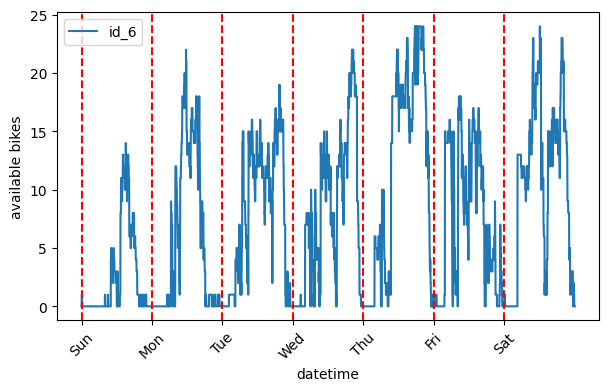

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Convert record_timestamp to datetime
df['record_timestamp'] = pd.to_datetime(df['record_timestamp'])

# Sort dataframe by record_timestamp
df.sort_values('record_timestamp', inplace=True)

# Filter data from date range
df = df[(df['record_timestamp'] >= '2023-09-10') & (df['record_timestamp'] <= '2023-09-17')]

# Plotting
plt.figure(figsize=(7,4))

# Plot for id_6
plt.plot(df['record_timestamp'], df['nb_velos_dispo'], label='id_6')


# Generate midnight times
midnights = pd.date_range(start=df['record_timestamp'].min(), end=df['record_timestamp'].max(), freq='D', normalize=True)

# Add vertical lines at each midnight
for midnight in midnights:
    plt.axvline(x=midnight, color='r', linestyle='--')
    
# Set x-axis tick labels
plt.xticks(midnights, [midnight.strftime("%A")[:3] for midnight in midnights], rotation=45)


plt.xlabel('datetime')
plt.ylabel('available bikes')
plt.legend()
plt.show()

# Query to get the total number of bikes, function of record_timestamp

In [18]:
query = f"""
SELECT
    record_timestamp,
    SUM(nb_velos_dispo) as total_bikes
FROM
    `{DATASET_NAME}.records_copy`
WHERE
    record_timestamp >= '2023-09-10'
GROUP BY
    record_timestamp
"""

df = pandas_gbq.read_gbq(query, project_id=PROJECT_ID)

# sort dataframe by record_timestamp
df.sort_values('record_timestamp', inplace=True)

display(df.head())

Downloading: 100%|██████████|


,record_timestamp,total_bikes
51581,2023-09-10 00:00:21.872000+00:00,1976
2182,2023-09-10 00:01:01.276000+00:00,1980
174401,2023-09-10 00:02:01.293000+00:00,1980
164691,2023-09-10 00:03:06.406000+00:00,1984
37546,2023-09-10 00:04:00.862000+00:00,1984


In [14]:
# Save the dataframe to a csv file
df.to_csv('total_bikes_per_day.csv', index=False)

In [27]:
df_week = df[(df['record_timestamp'] >= '2024-01-07') & (df['record_timestamp'] <= '2024-01-14')]

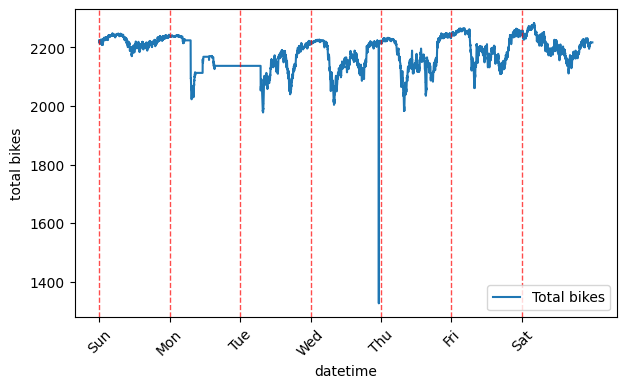

In [30]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(7,4))

# Plot for total bikes
plt.plot(df_week['record_timestamp'], df_week['total_bikes'], label='Total bikes')

# Generate midnight times
midnights = pd.date_range(start=df_week['record_timestamp'].min(), end=df_week['record_timestamp'].max(), freq='D', normalize=True)

# Add vertical lines at each midnight
for midnight in midnights:
    plt.axvline(x=midnight, color='r', linestyle='--', linewidth=1, alpha=0.7)
    
# Set x-axis tick labels
plt.xticks(midnights, [midnight.strftime("%A")[:3] for midnight in midnights], rotation=45)

plt.xlabel('datetime')
plt.ylabel('total bikes')
plt.legend()
plt.show()

## We need to detect 2 phenomenas:
- The frozen API time window that we can observe on the monday to tuesday's night
- The down peak of bikes close to the thursday midnight
  
The first one is easy to detect, we can see that the number of bikes is constant for a long time, and then it changes. We can detect this by looking at the time difference between the records. If the time difference is too big, we can assume that the API is frozen.

The second one is a little bit more tricky. We can see that the number of bikes is decreasing, and then it increases again. We can detect this by looking at the number of bikes and the time difference between the records. If the number of bikes is decreasing and the time difference is too big, we can assume that the API is frozen.

All the data of these 2 phenomenas need to be removed from the dataset to avoid bias in the analysis.